### 分享實作SVM模型預測，股票是不是會漲
 條件是：使用"股票技術指標"任選N種當作feature  
 依照課程影片最後看簡單的回測結果

In [202]:
import numpy as np
import pandas as pd
import talib
import finlab
from talib import abstract

finlab.SPECIFIC_HISTORY_FOLDER = '/Users/yungching/Documents/history'

from finlab import ml
from finlab.data import Data

folder = '/Users/yungching/Documents/history/items/price'

columns = ['open', 'high', 'low', 'close', 'volume']
files = ['開盤價', '最高價', '最低價' ,'收盤價', '成交筆數']

stock_id = '2412'

df = pd.DataFrame()

for idx, filename in enumerate(files):
    df_temp = pd.read_pickle(f"{folder}/{filename}.pkl")
    s = df_temp[stock_id]
    df[columns[idx]] = s
    df[columns[idx]].fillna(method='ffill', inplace=True)

df['Name'] = stock_id

### 取得指標內容

In [203]:
indicators = {}

for fname in dir(abstract):
    if fname[:2] == '__':
        continue
        
    if fname[:3] == 'CDL':
        continue
    
    if 'FLAGS' in fname:
        continue
        
    if fname.upper() != fname:
        continue
    try:
        f = getattr(abstract, fname)
        indicators[fname] = f(df).dropna()
    except:
        print(f'execute talib.{fname} fail.')
        pass

execute talib.MAVP fail.


### 處理指標內容

In [204]:
expected_indicators = [ 'ADX', 'PLUS_DI', 'MINUS_DI' ]

df_ind = pd.DataFrame(index=df.index)

for name, indicator in indicators.items():
    if indicator.empty:
        continue
    if not name in expected_indicators:
        continue

    if isinstance(indicator, pd.DataFrame):
        df_ind = df_ind.append(indicator)
    elif isinstance(indicator, pd.Series):
        df_ind[name] = indicator
        pass
    else:
        continue

df_ind = df_ind.dropna()

In [205]:
def add_profit_prediction(dataset, sid, n=1):
    
    dates = sorted(list(set(dataset.reset_index()['date'])))
    
    adj_open = ml.data.get_adj('開盤價')
    
    tomorrow_adj_open = adj_open.shift(-1)
    tomorrow_adj_open = tomorrow_adj_open.reindex(dates, method='bfill')
    
    
    p = (tomorrow_adj_open.shift(-n) / tomorrow_adj_open)
    dataset['return'] = p[sid]

add_profit_prediction(df_ind, stock_id)

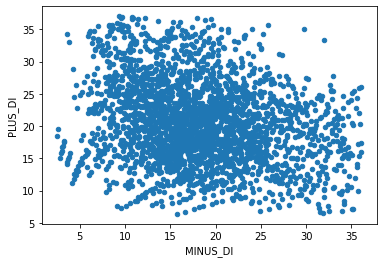

In [206]:
def is_valid(feature, nstd):
    ub = feature.mean() + nstd * feature.std()
    lb = feature.mean() - nstd * feature.std()

    return (feature > lb) & (feature <ub)

valid = is_valid(df_ind['ADX'], 2) & \
        is_valid(df_ind['MINUS_DI'], 2) & \
        is_valid(df_ind['PLUS_DI'], 2)

df_rmoutliers = df_ind[valid].dropna()
df_rmoutliers

df_rmoutliers.plot.scatter('MINUS_DI', 'PLUS_DI')

In [207]:
import sklearn.preprocessing as preprocessing

df_scaled = pd.DataFrame(preprocessing.scale(df_rmoutliers), \
                        index=df_rmoutliers.index, \
                        columns=df_rmoutliers.columns)

df_scaled['return'] = df_rmoutliers['return']
df_scaled.head()

,ADX,MINUS_DI,PLUS_DI,return
date,,,,
2007-05-31,-0.107717,1.238830,-0.785376,1.001603
2007-06-01,-0.077893,0.957560,-0.963401,1.000000
2007-06-04,-0.155597,0.737225,-0.333503,0.995200
2007-06-05,-0.173222,0.977486,-0.578639,0.996785
2007-06-06,-0.155837,1.066032,-0.771328,1.000000


### traning model

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

df_train, df_test = train_test_split(df_scaled, test_size=0.1, random_state=0)

cf = SVC(C=1., cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto',
        kernel='rbf', max_iter=-1, probability=False, random_state=None,
        shrinking=True, tol=0.001, verbose=False)

cf.fit(df_train[expected_indicators], \
        df_train['return'] > df_train['return'].quantile(0.5))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [209]:
cf.score(df_test[expected_indicators], \
         df_test['return'] > df_train['return'].quantile(0.5))

0.5538461538461539

In [210]:
# cf.predict(df_test[expected_indicators])

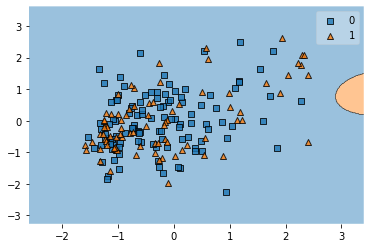

In [211]:
from mlxtend.plotting import plot_decision_regions

features_plot = df_test[expected_indicators].values
labels_plot = (df_test['return'] > df_test['return'].quantile(0.5)).astype(int).values

value=0
width=1.2
plot_decision_regions(features_plot, labels_plot, 
                    filler_feature_values={2: value},
                    filler_feature_ranges={2: width}, 
                    clf=cf)